In [1]:
import os
import json
import pandas as pd
import sqlite3
import numpy as np
from tqdm.notebook import tqdm
import pickle

# 1. Load Metadata

In [2]:
os.listdir("./datasets")

['train_triplets.txt',
 '7D_id_to_path.pkl',
 'crawl',
 'MSD_id_to_7D_id.pkl',
 'olga',
 'track_metadata.db']

In [3]:
con = sqlite3.connect("./datasets/track_metadata.db")
msd_db = pd.read_sql_query("SELECT * FROM songs", con)

In [4]:
msd_db.head(2)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0


In [5]:
df_olga = pd.read_csv("./datasets/olga/olga.csv", index_col = 0) # we don't use tracks
df_olga.head(2)

,musicbrainz_id,partition,tracks
index,,,
0,c5b11a19-5ba6-4554-a65b-e505c3296d48,train,"['0376162c-24b4-4b52-a351-185e40de9b71', '1607..."
1,252ca659-19c6-46e1-a464-c4b80300bb02,train,"['029aebb5-4991-435a-90db-f56122c8fc4c', '0432..."


In [6]:
df_olga

,musicbrainz_id,partition,tracks
index,,,
0,c5b11a19-5ba6-4554-a65b-e505c3296d48,train,"['0376162c-24b4-4b52-a351-185e40de9b71', '1607..."
1,252ca659-19c6-46e1-a464-c4b80300bb02,train,"['029aebb5-4991-435a-90db-f56122c8fc4c', '0432..."
2,b9f29919-5d08-498d-bcfc-fda33deceade,train,"['073902fd-e188-416d-aeec-49c9c7fdf4d7', '0984..."
3,1b396d40-a35a-4558-b292-0b2685f7ea8f,train,"['0a3e1513-cc41-4234-9245-3f15adefef46', '1b07..."
4,84cff711-6d4f-49b9-bc54-f4db4c7addfb,train,"['02911df4-a535-4da0-bd0f-06027f31da6c', '091b..."
...,...,...,...
17668,4c8571fc-17ea-4eae-8a31-8d09997011e6,test,"['1b7ed759-4e54-4d08-a55f-c5cb6d008034', '1cde..."
17669,936f9130-333f-40dd-813f-6da80fd95c11,test,"['04c957e9-46be-4c2c-a455-1f2b88db8822', '0ad0..."
17670,b6b6f1cf-e1c8-46e9-bc54-1a63ed1f8d51,test,"['04367c6a-7f42-4f46-a471-1805c2f950ac', '0520..."


# 2. OLGA to MSD

In [7]:
# thanks to Andres!
merged = (
    pd.DataFrame({'song_id': msd_db['song_id'].unique()}).merge(
        msd_db.merge(
            (
                df_olga
                .rename(columns={'musicbrainz_id': 'artist_mbid'})
                .drop(['partition', 'tracks'], axis=1)
            ),
            how='inner',
            on='artist_mbid'
        ),
        how='inner',
        on='song_id'
    )
)

In [8]:
merged.head(2)

,song_id,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,SOQMMHC12AB0180CB8,TRMMMYQ128F932D901,Silent Night,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,SOGTUKN12AB017F4F1,TRMMMRX128F93187D9,No One Could Ever,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0


In [9]:
merged = merged.set_index("artist_mbid")

In [10]:
olga_to_msd, unique_tracks = {}, []
for mbid in tqdm(df_olga['musicbrainz_id']):
    instance = merged.loc[mbid]
    if type(instance) == pd.core.frame.DataFrame:
        paired_track = list(set(instance['track_id']))
    else: # single instance case
        paired_track = [instance['track_id']]
    olga_to_msd[mbid] = paired_track
    unique_tracks.extend(paired_track)

  0%|          | 0/17673 [00:00<?, ?it/s]

In [11]:
len(unique_tracks), len(set(unique_tracks)) # 552k msd tracks are connected to OLGA Artist.

(552960, 552960)

In [12]:
list(olga_to_msd.items())[0]

('c5b11a19-5ba6-4554-a65b-e505c3296d48',
 ['TRFNHSW12903CE05E7',
  'TRLTWWT12903CE05E2',
  'TRDXBLR12903CE05EA',
  'TRDVJVX12903CE05D0',
  'TRXGLJP12903CE05D3',
  'TRRNNZM12903CE05C8',
  'TRGYKVB12903CE05CD',
  'TRBXMMJ12903CE05DB',
  'TRDJOPM12903CE05DE',
  'TRPLSLX12903CE05D7'])

# 3. Statistics

avg:  31  min:  1  max:  208


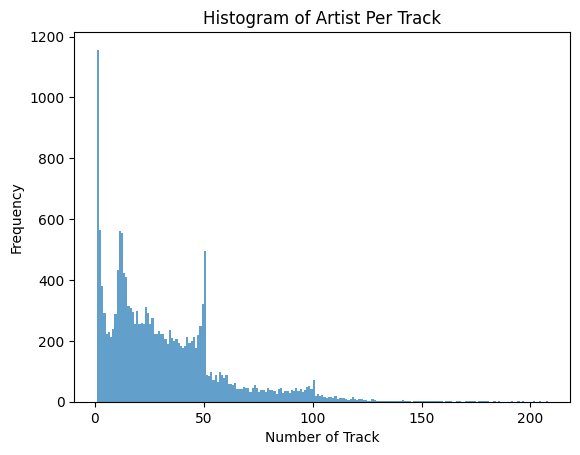

In [13]:
import matplotlib.pyplot as plt
artist_per_track = [len(track_ids) for artist, track_ids in olga_to_msd.items()]
print("avg: ", int(np.mean(artist_per_track)), " min: ",np.min(artist_per_track), " max: ",np.max(artist_per_track))
plt.hist(artist_per_track, bins=range(min(artist_per_track), max(artist_per_track) + 1), alpha=0.7)
plt.title('Histogram of Artist Per Track')
plt.xlabel('Number of Track')
plt.ylabel('Frequency')
plt.show()

In [14]:
less_track_artist = [x for x in artist_per_track if x <= 25]
many_track_arist = [x for x in artist_per_track if x > 100]
print("less than 25 track artist: ", (len(less_track_artist) / len(artist_per_track)))
print("more than 100 track artist: ", (len(many_track_arist) / len(artist_per_track)))

less than 25 track artist:  0.5130424942001924
more than 100 track artist:  0.023651898376053866


# 4. Popular Artist

according to [Contrastive Learning for Cross-modal Artist Retrieval](https://arxiv.org/abs/2308.06556), popular artist define as,

```
3.4 Effect of Popularity
Artist popularity may be a deterministic factor in artist retrieval, both for training and evaluation. Intuitively, we likely have more data about popular artists, which implies more multimodal data is available for training. At the same time, the scale of evaluation metric themselves can be inflated as more popular artists would have more ground truths (annotated as ‘similar artists’). To confirm this, we compute a proxy measure for the artist popularity (POP) as
```

$$
\text{POP(artist)} = \log{(\# listen + 1)}
$$

```
#listen denotes the total listening count of the artist, computed from the MSD-Echonest Profile dataset
```

In [15]:
echonest = open("./datasets/train_triplets.txt").readlines()

In [16]:
profile_dataset = []
for item in echonest:
    user, item, count = item.strip().split("\t")
    profile_dataset.append({
        "user_id": user,
        "song_id": item,
        "count": int(count)
    })
df_profile = pd.DataFrame(profile_dataset)
df_profile.head(2)

,user_id,song_id,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1


In [17]:
df_merge = pd.merge(msd_db.reset_index(), df_profile, on='song_id', how='outer')
df_pop = df_merge.groupby('artist_mbid')['count'].sum().reset_index()
df_pop["pop"] = np.log10(df_pop['count'] + 1)

In [18]:
df_pop = df_pop.set_index("artist_mbid").loc[df_olga["musicbrainz_id"]]

In [19]:
df_pop.head(5)

,count,pop
artist_mbid,,
c5b11a19-5ba6-4554-a65b-e505c3296d48,0.0,0.000000
252ca659-19c6-46e1-a464-c4b80300bb02,204.0,2.311754
b9f29919-5d08-498d-bcfc-fda33deceade,110.0,2.045323
1b396d40-a35a-4558-b292-0b2685f7ea8f,318.0,2.503791
84cff711-6d4f-49b9-bc54-f4db4c7addfb,1837.0,3.264346


# 5. Check Missing Tracks

There may be problems with MSD Audio for each research group, and there may be cases where audio is lost. Check for this.

In [20]:
msd_to_id = pickle.load(open(os.path.join("./datasets", "MSD_id_to_7D_id.pkl"), 'rb'))
id_to_path = pickle.load(open(os.path.join("./datasets", "7D_id_to_path.pkl"), 'rb'))

In [21]:
msd_dir = "/data/seungheon/dataset/msd/npy"

In [22]:
_olga_to_msd = {k:[] for k in olga_to_msd.keys()}
save_msd, error_msd = [], []
for artist_mid, track_ids in tqdm(olga_to_msd.items()):
    filter_track_ids = []
    for track_id in track_ids:
        try:
            path = id_to_path[msd_to_id[track_id]].replace(".mp3", ".npy")
            kaist_msd_path = os.path.join(msd_dir, path)
            if os.path.isfile(kaist_msd_path):
                filter_track_ids.append(track_id)
            else:
                error_msd.append(track_id)
        except:
            error_msd.append(track_id)
    save_msd.extend(list(set(filter_track_ids)))
    _olga_to_msd[artist_mid] = list(set(filter_track_ids))

  0%|          | 0/17673 [00:00<?, ?it/s]

In [25]:
# At least one track per artist is preserved, but 8429 tracks are not available.
error_cases = [k for k,v in list(_olga_to_msd.items()) if len(v) == 0]
len(error_cases), len(save_msd), len(error_msd)

(0, 544531, 8429)

In [26]:
with open("./olga_to_msd.json", "w") as json_file:
    json.dump(_olga_to_msd, json_file, indent=4)